In [1]:
# !pip3 install torch torchvision networkx scikit-learn

In [2]:
# next we show the same in torch with a simple model.
import torch
import torch.nn as nn
import torch.nn.functional as F

import networkx as nx
from sklearn.model_selection import train_test_split

from dfederation import TorchNode, FederatedCommunity, get_data, ModelScoreFunc


In [3]:

# Split the data:
X_train, X_test, y_train, y_test = train_test_split(
    get_data()['images'], get_data()['target'], 
    test_size=0.2, shuffle=True, random_state=42
)


In [4]:
# Define the model

class SimpleNet(nn.Module):

    def __init__(self):
        super(SimpleNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=3)
        self.fc1 = nn.Linear(90, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = x.view(-1, 90)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

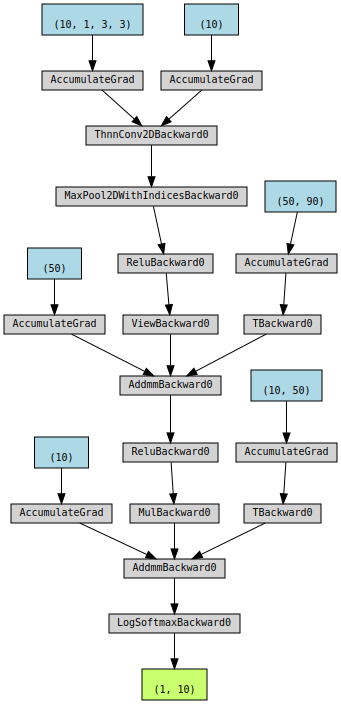

In [23]:
# !pip3 install torchviz

from torchviz import make_dot

make_dot(SimpleNet()(torch.rand(1, 1, 8, 8)), params=dict(SimpleNet().named_parameters()))

In [15]:
import numpy as np

# create the topology:
topology = nx.DiGraph()
# two nodes:
for i in range(2):
    model = SimpleNet()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    criterion = nn.NLLLoss()

    topology.add_node(
        i, 
        node=TorchNode(
            model, node_id=i, 
            criterion=criterion, optimizer=optimizer,
            model_score_func=ModelScoreFunc.TORCH_SCORE_FUNC_NLL_LOSS
        )
    )

# connect them:
topology.add_edge(0, 1)
topology.add_edge(1, 0)

# create the federated community:
community = FederatedCommunity(topology)

In [16]:

# Communicate a few times to equilibriate the community:
community.communicate(times=2)

# Get scores. (Will be bad!)
print(community.get_scores(X_test, y_test))


{0: 2.358139657974243, 1: 2.4716318064265783}


In [17]:

# Now split the training data in half:
X_trains = [
    X_train[:len(X_train)//2],
    X_train[len(X_train)//2:]
]
y_trains = [
    y_train[:len(y_train)//2],
    y_train[len(y_train)//2:]
]

scores_over_time = []
for epoch in range(10):
    # Train each node on half of the data:
    for i in range(2):
        for n in range(len(X_trains[i])):
            community.train(X_trains[i][n], y_trains[i][n], i)

    community.communicate(times=3)
    scores_over_time.append(community.get_scores(X_test, y_test))


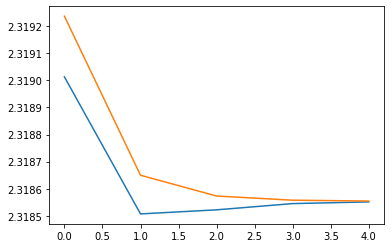

In [8]:
# plot scores_over_time; array of dicts: keys are node names, values are score
import matplotlib.pyplot as plt

for k in scores_over_time[0].keys():
    plt.plot(
        [x[k] for x in scores_over_time],
        label=k
    )

In [10]:
community.get_scores(X_test, y_test)

{0: 2.318551239040163, 1: 2.3185545159710776}